# Model

## Check for acceleration

In [1]:
!nvidia-smi

Sun Jul  4 13:08:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [2]:
import numpy as np
np.random.seed(2021)
import tensorflow as tf
tf.random.set_seed(2021)
import random
random.seed(2021)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import math

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras.layers as L
from keras.layers import Dense
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1.logging import INFO, set_verbosity
from tqdm import tqdm

from IPython.display import YouTubeVideo

set_verbosity(INFO)

## Constants

In [3]:
DATA_DIR = 'data/'
os.makedirs(DATA_DIR, exist_ok=True)

CSV_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_bb_onehot.csv')
IMAGES_ARCHIVE_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_256x256.tar.gz')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')

## Download the prepared dataset

In [4]:
if not os.path.exists(CSV_FILE):
    ! gdown --id 1i7oUN9QTjOavTPGgvWKq22InrTFN6mYH -O $CSV_FILE
else:
    print('CSV file ({}) already exists.'.format(CSV_FILE))

CSV file (data/nih_chest_xray_single_9c_bb_onehot.csv) already exists.


In [5]:
if not os.path.exists(IMAGES_ARCHIVE_FILE):
    ! gdown --id 1Cg7dbE1tWSBvdTfGc0G272SA_j_XocOW -O $IMAGES_ARCHIVE_FILE
else:
    print('Images archive file ({}) already exists.'.format(IMAGES_ARCHIVE_FILE))

Images archive file (data/nih_chest_xray_single_9c_256x256.tar.gz) already exists.


In [6]:
if not os.path.exists(IMAGES_DIR):
    ! tar -xzf $IMAGES_ARCHIVE_FILE
    print('Unpacked to {}'.format(IMAGES_DIR))
else:
    print('Images have already been unpacked ({}).'.format(IMAGES_DIR))

Images have already been unpacked (data/images).


## Explore the dataset

Tasks:

1. Read the CSV file and explore the data


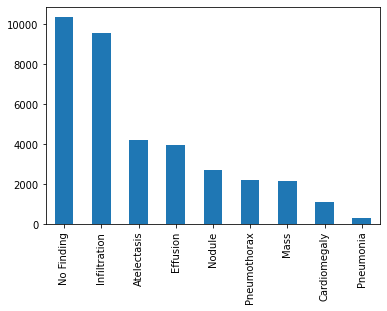

In [7]:
## Read the CSV file
df_base = pd.read_csv(CSV_FILE)
df_base

df_base['Finding Labels'].value_counts().plot(kind='bar')

### Prepare Data for Training and Testing

Tasks:

1. Create new dataframe with only 'Pneumothorax' and 'Mass' labels.
2. Split the two-class dataframe into train, validation and test dataframes with `train_test_split`. Each call will split the data into two, so we need to call it twice to get `train`, `val` and `test` sets.

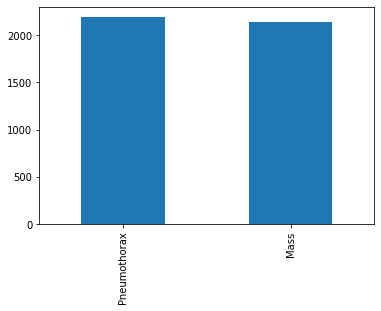

In [8]:
## Create new dataframe with only 'Pneumothorax' and 'Mass' labels
LABELS = ['Pneumothorax', 'Mass']
df = df_base[df_base['Finding Labels'].str.match('|'.join(LABELS))]
df['Finding Labels'].value_counts().plot(kind='bar')

In [9]:
TEST_SIZE = 0.15
VAL_SIZE = 0.15

In [10]:
## Split the two-class dataframe into train, validation and test dataframes with
## `train_test_split`. Each call will split the data into two, so we need to call
## it twice to get `train`, `val` and `test` sets.

tmp_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=2021,
    shuffle=True,
    stratify=df['Finding Labels']
)

train_df, val_df = train_test_split(
    tmp_df,
    test_size=VAL_SIZE/(1.0-TEST_SIZE),
    random_state=2021,
    shuffle=True,
    stratify=tmp_df['Finding Labels']
)

In [11]:
print(len(df))
print(len(train_df))
print(len(val_df))
print(len(test_df))
print()
print(len(train_df)/len(df)*100)
print(len(val_df)/len(df)*100)
print(len(test_df)/len(df)*100)

4333
3033
650
650

69.99769213016386
15.00115393491807
15.00115393491807


Pneumothorax    1536
Mass            1497
Name: Finding Labels, dtype: int64


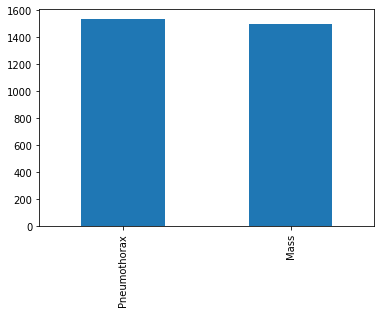

In [12]:
print(train_df['Finding Labels'].value_counts())
train_df['Finding Labels'].value_counts().plot(kind='bar')

## Create data pipeline

Tasks:

1. Create data pipeline for training
   
   Use `ImageDataGenerator` and `flow_from_dataframe` to build an image pre-processing pipeline that will feed training with structured data.

1. Create data pipeline for testing and validation

  Do the same for testing and validation. You should also compute quantities required for featurewise normalization (like mean and standard deviation) on training data and fit test/validation generators on it.

Useful resources:

* https://keras.io/api/preprocessing/image/
* https://fairyonice.github.io/Learn-about-ImageDataGenerator.html


In [31]:
## Create data pipeline for training

BATCH_SIZE = 32
IMAGE_SIZE = [128, 128]

def get_train_generator(df, labels, batch_size, image_size,
                        color_mode='grayscale', file_path_col='File Path'):
    ## START
    image_generator = ImageDataGenerator(
        samplewise_center=True,  # Set each sample mean to 0.
        samplewise_std_normalization=True,  # Divide each input by its std
        rotation_range=5,  # Degree range for random rotations
        width_shift_range=0.1,  # fraction of total width
        height_shift_range=0.05,  # fraction of total height
        shear_range=0.1,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        zoom_range=0.15,  # Range for random zoom
        fill_mode='reflect',  # fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}
        horizontal_flip=True,  # Randomly flip inputs horizontally.
        vertical_flip=False,  # Randomly flip inputs vertically.
    )

    generator = image_generator.flow_from_dataframe(
        dataframe=df,  # Pandas dataframe containing the filepaths relative to directory (or absolute paths if directory is None)
        x_col=file_path_col,  # column in dataframe that contains the filenames
        y_col=labels,  # string or list, column/s in dataframe that has the target data.
        class_mode='raw',  # "raw": numpy array of values in y_col column(s)
        batch_size=batch_size,  # size of the batches of data
        shuffle=True,  # whether to shuffle the data (default: True)
        seed=2021,  # optional random seed for shuffling and transformations.
        target_size=image_size,  # tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.
        color_mode=color_mode,  # one of "grayscale", "rgb", "rgba"
    )
    ## END
    return generator

train_generator = get_train_generator(
    df=train_df,
    labels=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

Found 3033 validated image filenames.


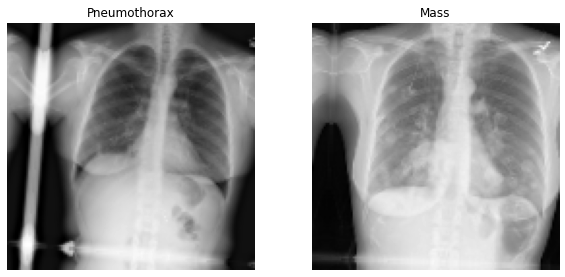

In [14]:
def get_label(label_encoding, labels):
    for i, val in enumerate(label_encoding):
        if val:
            return labels[i]
    return 'No Label'

x, y = train_generator.__getitem__(0)

samples = 2

fig = plt.figure(figsize=(20, 10))
for i in range(samples):
    label = get_label(y[i], LABELS)
    img_processed = x[i].squeeze()

    fig.add_subplot(samples, i+1, 1)
    plt.imshow(img_processed, cmap='gray')
    plt.title('{}'.format(label))
    plt.axis(False)

In [32]:
## Create data pipeline for testing and validation
def get_test_and_valid_generator(val_df, test_df, train_df, labels, batch_size, image_size,
                                 color_mode='grayscale', file_path_col='File Path'):
    ## START
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        x_col=file_path_col,
        y_col=labels, 
        class_mode="raw", 
        batch_size=100,  # sample size, we will be loading only the first batch
        shuffle=True,
        seed=2021,
        target_size=image_size,
        color_mode=color_mode,
    )
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col=file_path_col,
        y_col=labels,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        target_size=image_size,
        color_mode=color_mode,
    )

    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col=file_path_col,
        y_col=labels,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        target_size=image_size,
        color_mode=color_mode,
    )
    ## END
    return valid_generator, test_generator

val_generator, test_generator= get_test_and_valid_generator(
    val_df=val_df,
    test_df=test_df,
    train_df=train_df,
    labels=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)


Found 3033 validated image filenames.
Found 650 validated image filenames.
Found 650 validated image filenames.


## Training

In [16]:
def visualize_training(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth=3)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth=3)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth=3)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth=3)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()

In [17]:
EPOCHS = 10

### Shallow Model

Tasks:

1. Create a shallow model based on LeNet-5

Epoch 1/10
95/95 [==============================] - 11s 98ms/step - loss: 0.6826 - accuracy: 0.5687 - val_loss: 0.7026 - val_accuracy: 0.4985
Epoch 2/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6699 - accuracy: 0.5879 - val_loss: 0.7242 - val_accuracy: 0.4908
Epoch 3/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6681 - accuracy: 0.6073 - val_loss: 0.7153 - val_accuracy: 0.5077
Epoch 4/10
95/95 [==============================] - 9s 98ms/step - loss: 0.6580 - accuracy: 0.6103 - val_loss: 0.7379 - val_accuracy: 0.5215
Epoch 5/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6465 - accuracy: 0.6327 - val_loss: 0.7228 - val_accuracy: 0.5446
Epoch 6/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6470 - accuracy: 0.6264 - val_loss: 0.7247 - val_accuracy: 0.5262
Epoch 7/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6402 - accuracy: 0.6317 - val_loss: 0.7563 - val_accuracy: 0.5246
Epoch 8/10
9

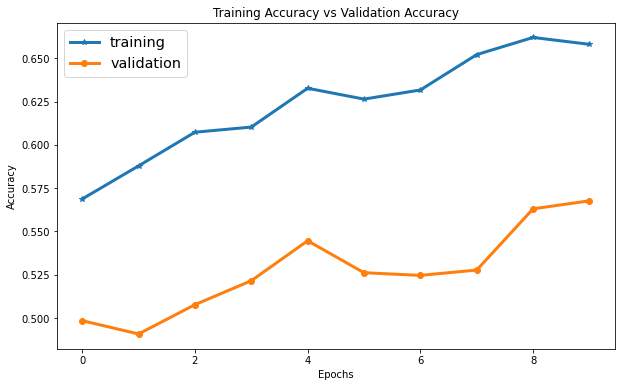

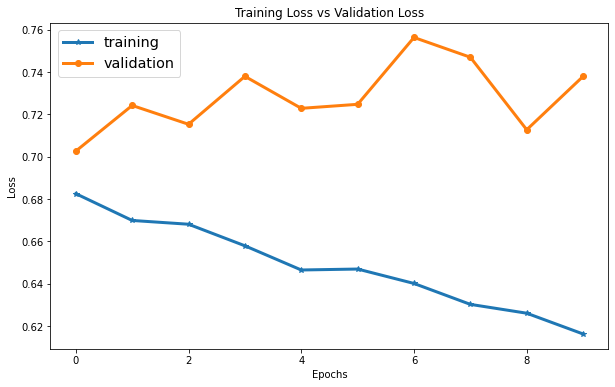

CPU times: user 1min 39s, sys: 2.93 s, total: 1min 42s
Wall time: 1min 35s


In [18]:
%%time
##

model_1 = tf.keras.Sequential(
    layers=[
        ## START
        L.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
        L.MaxPool2D(),
        L.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),
        L.MaxPool2D(),
        L.Flatten(),
        L.Dense(units=256, activation='relu'),
        L.Dense(units=84, activation='relu'),
        L.Dense(len(LABELS), activation='softmax'),
        ## END
    ],
    name='Model_Shallow',
)

model_1.compile(
    ## START
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    ## END
)

history_1 = model_1.fit(
    ## START
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    ## END
)

visualize_training(history_1)


### Regularization

Tasks:
1. try to fix model's poor performance using common regularization techniques - dropout and L1/L2 regularization

Useful resources:

* https://keras.io/api/layers/regularization_layers/dropout/
* https://keras.io/api/layers/regularizers/

Epoch 1/10
95/95 [==============================] - 10s 100ms/step - loss: 0.6899 - accuracy: 0.5443 - val_loss: 0.6980 - val_accuracy: 0.5138
Epoch 2/10
95/95 [==============================] - 9s 96ms/step - loss: 0.6784 - accuracy: 0.5846 - val_loss: 0.6984 - val_accuracy: 0.5031
Epoch 3/10
95/95 [==============================] - 9s 96ms/step - loss: 0.6726 - accuracy: 0.5915 - val_loss: 0.6912 - val_accuracy: 0.5169
Epoch 4/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6687 - accuracy: 0.5925 - val_loss: 0.7230 - val_accuracy: 0.5031
Epoch 5/10
95/95 [==============================] - 9s 97ms/step - loss: 0.6605 - accuracy: 0.6103 - val_loss: 0.7146 - val_accuracy: 0.5077
Epoch 6/10
95/95 [==============================] - 9s 96ms/step - loss: 0.6506 - accuracy: 0.6245 - val_loss: 0.7109 - val_accuracy: 0.5538
Epoch 7/10
95/95 [==============================] - 9s 98ms/step - loss: 0.6485 - accuracy: 0.6320 - val_loss: 0.7247 - val_accuracy: 0.5385
Epoch 8/10


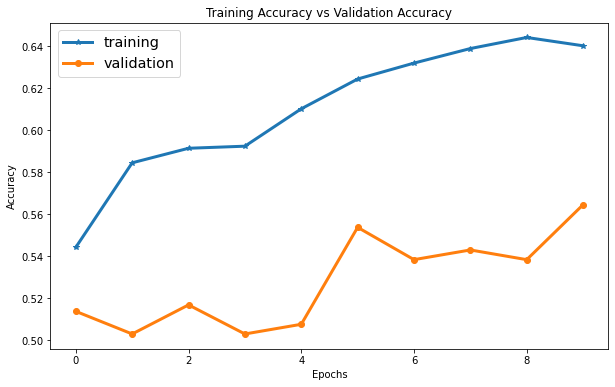

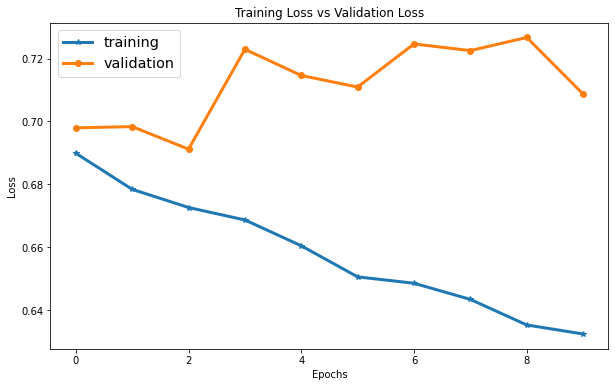

CPU times: user 1min 37s, sys: 2.04 s, total: 1min 39s
Wall time: 1min 33s


In [19]:
%%time
##

model_dropout = tf.keras.Sequential(
    layers = [
        ## START
        L.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
        L.MaxPool2D(),
        L.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),
        L.MaxPool2D(),
        L.Flatten(),
        L.Dense(units=256, activation='relu'),
        L.Dropout(0.2), ## 1
        L.Dense(units=84, activation='relu'),
        L.Dropout(0.2), ## 1
        L.Dense(len(LABELS), activation='softmax'),
        ## END
    ],
    name='Model_Dropout',
)

model_dropout.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
)

history_dropout = model_dropout.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=EPOCHS,
)

visualize_training(history_dropout)


Model: "Model_Regularization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 48)        38448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 48)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40368)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               10334464  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)      

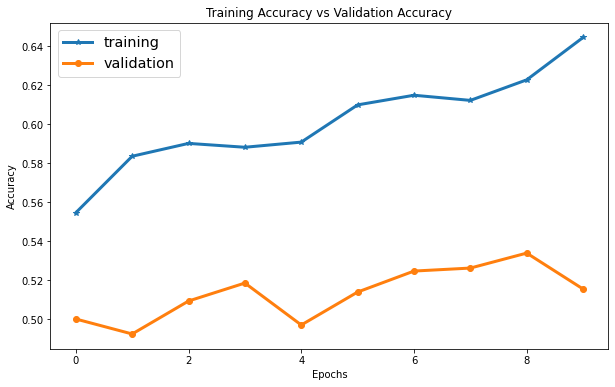

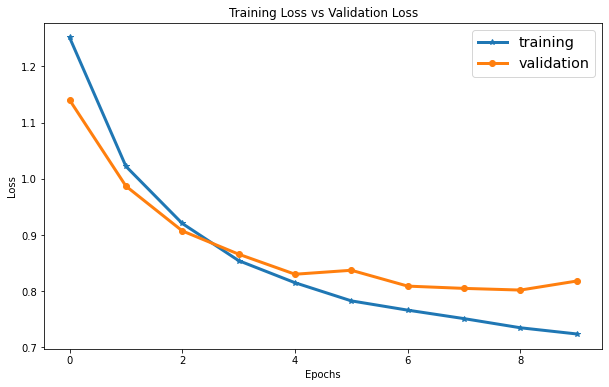

CPU times: user 1min 39s, sys: 2.31 s, total: 1min 41s
Wall time: 1min 34s


In [20]:
%%time

from tensorflow.keras.regularizers import l1_l2 as L1L2
from tensorflow.keras.regularizers import l2 as L2

model_reg = tf.keras.Sequential(
    layers=[
        ## START
        L.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
        L.MaxPool2D(),
        L.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),
        L.MaxPool2D(),
        L.Flatten(),
        L.Dense(units=256, activation='relu',
                kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
                activity_regularizer=L2(1e-5)
        ), ## 3
        L.Dropout(0.2),
        L.Dense(units=84, activation='relu',
                kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
                activity_regularizer=L2(1e-5)
        ), ## 3
        L.Dropout(0.2),
        L.Dense(len(LABELS), activation='softmax'),
        ## END
    ],
    name='Model_Regularization',
)

model_reg.summary()

model_reg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
)

history_reg = model_reg.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=EPOCHS,
)

visualize_training(history_reg)


### Early Stopping

Tasks:

1. Try to reduce training time by using early stopping once model reaches satisfactory performance

Useful resources:

* https://keras.io/api/callbacks/early_stopping/

Epoch 1/10
95/95 [==============================] - 27s 99ms/step - loss: 1.2551 - accuracy: 0.5539 - val_loss: 1.1506 - val_accuracy: 0.4831
Epoch 2/10
95/95 [==============================] - 9s 97ms/step - loss: 1.0530 - accuracy: 0.5829 - val_loss: 1.0197 - val_accuracy: 0.4877
Epoch 3/10
95/95 [==============================] - 9s 97ms/step - loss: 0.9535 - accuracy: 0.5961 - val_loss: 0.9586 - val_accuracy: 0.5015
Epoch 4/10
95/95 [==============================] - 9s 96ms/step - loss: 0.8960 - accuracy: 0.6136 - val_loss: 0.9237 - val_accuracy: 0.5200
Epoch 5/10
95/95 [==============================] - 9s 96ms/step - loss: 0.8617 - accuracy: 0.5895 - val_loss: 0.8906 - val_accuracy: 0.5215
Epoch 6/10
95/95 [==============================] - 9s 97ms/step - loss: 0.8232 - accuracy: 0.6235 - val_loss: 0.8814 - val_accuracy: 0.5108
Epoch 00006: early stopping


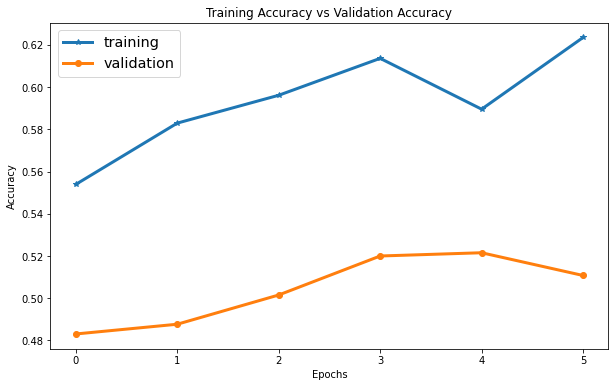

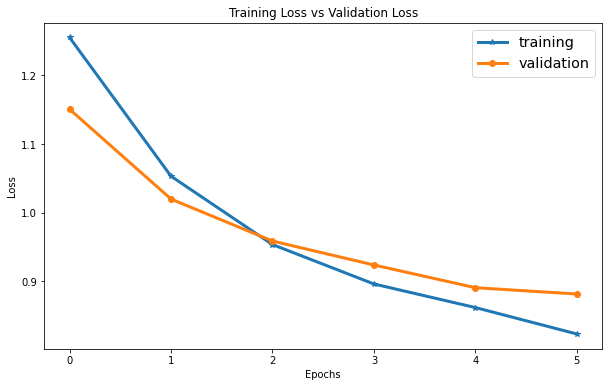

CPU times: user 1min, sys: 1.37 s, total: 1min 1s
Wall time: 1min 12s


In [42]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

model_earlystop = tf.keras.Sequential(
    layers=[
        L.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
        L.MaxPool2D(),
        L.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),
        L.MaxPool2D(),
        L.Flatten(),
        L.Dense(units=256, activation='relu',
                kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
                activity_regularizer=L2(1e-5)
        ),
        L.Dropout(0.2),
        L.Dense(units=84, activation='relu',
                kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
                activity_regularizer=L2(1e-5)
        ),
        L.Dropout(0.2),
        L.Dense(len(LABELS), activation='softmax'),
    ],
    name='Model_EarlyStop'
)

model_earlystop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

## START
early_stopping_custom = EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    verbose=1,
)
## END

history_earlystop = model_earlystop.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    ## START
    callbacks=[early_stopping_custom],
    ## END
)

visualize_training(history_earlystop)


### Transfer Learning

Tasks:

1. To furtherly improve model's performance change the approach - instead of implementing your own model and training from scratch use existing model with pre-trained weights.

In [22]:
!pip install -q efficientnet

In [23]:
import efficientnet.tfkeras as efn

In [24]:
IMAGE_SIZE = [240, 240]  # https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [25]:
model_transfer = tf.keras.Sequential(
    layers=[
        ## START
        efn.EfficientNetB1(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False,
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation='relu', kernel_regularizer=L2(0.01)),
        L.Dropout(0.2),
        L.Dense(len(LABELS), activation='softmax'),
        ## END
    ],
    name='Model_TransferLearning',
)

In [26]:
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [27]:
train_generator = get_train_generator(
    df = train_df,
    file_path_col="File Path",
    labels=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode='rgb',  # if you run this cell then remember, that if you want to run any of the previous models
    # you have to go back and re-run generators with color_mode='grayscale'
)

val_generator, test_generator= get_test_and_valid_generator(
    val_df=val_df,
    test_df=test_df,
    train_df=train_df,
    file_path_col="File Path",
    labels=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode='rgb',
)

Found 3033 validated image filenames.
Found 3033 validated image filenames.
Found 650 validated image filenames.
Found 650 validated image filenames.


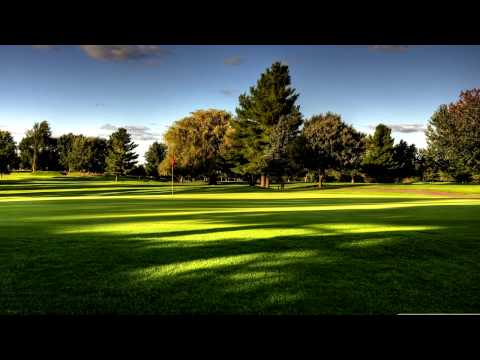

In [28]:
#@title
YouTubeVideo('QIlR0rX3Zx8')

Epoch 1/10
95/95 [==============================] - 62s 537ms/step - loss: 11.8309 - accuracy: 0.5265 - val_loss: 11.5706 - val_accuracy: 0.5523
Epoch 2/10
95/95 [==============================] - 49s 513ms/step - loss: 11.3182 - accuracy: 0.5806 - val_loss: 11.0738 - val_accuracy: 0.6123
Epoch 3/10
95/95 [==============================] - 49s 511ms/step - loss: 10.8275 - accuracy: 0.6370 - val_loss: 10.5931 - val_accuracy: 0.6431
Epoch 4/10
95/95 [==============================] - 49s 510ms/step - loss: 10.3528 - accuracy: 0.6578 - val_loss: 10.1284 - val_accuracy: 0.6662
Epoch 5/10
95/95 [==============================] - 48s 509ms/step - loss: 9.8870 - accuracy: 0.6963 - val_loss: 9.6707 - val_accuracy: 0.6769
Epoch 6/10
95/95 [==============================] - 49s 513ms/step - loss: 9.4465 - accuracy: 0.7079 - val_loss: 9.2395 - val_accuracy: 0.6815
Epoch 7/10
95/95 [==============================] - 48s 509ms/step - loss: 9.0226 - accuracy: 0.7029 - val_loss: 8.8269 - val_accuracy

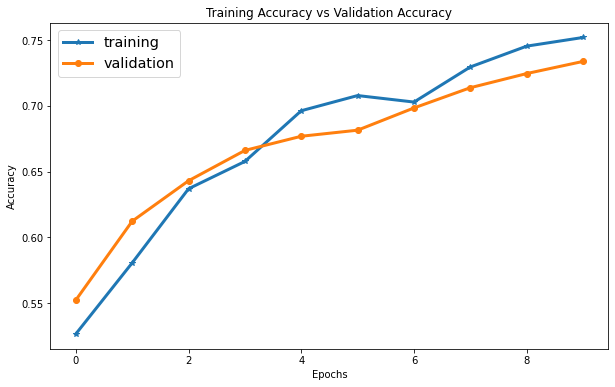

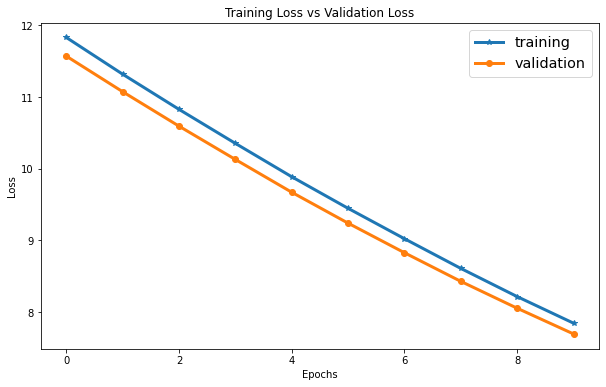

In [29]:
history = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=10,
    callbacks=[early_stopping_custom],
)

visualize_training(history)